<a href="https://colab.research.google.com/github/pmccthy/data-science-playground/blob/main/RNNs/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSTM RNNs**

Based on the tutorial at https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/. As per this tutorial, we are attempting to do time series prediction (regression) with the International Airline Passengers dataset. It is worth bearing in mind that LSTMs were developed to solve the vanishing gradient problem. A good explanation of how they do so can be found here: https://medium.datadriveninvestor.com/how-do-lstm-networks-solve-the-problem-of-vanishing-gradients-a6784971a577. 

In [2]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [4]:
# load data (units are 1000's of passengers per month)
dataframe = pandas.read_csv('data/airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

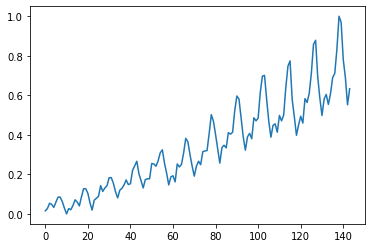

In [8]:
# normalise data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# visualise 
plt.plot(dataset)

In [9]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


It is now necessary to create a function which can be used to create a dataset including a 'lookback', which specifies the number of previous values to be used to predict the next data point. The values used for prediction for each datapoint will be isolated and then all of these concatenated to produce a dataset of the correct format.

In [10]:
# convert an array of values into a dataset matrix 
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [11]:
# create dataset for model
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [12]:
# reshape dataset to dimensions expected by LSTM blocks: [samples, time steps, features]
# in our case, we just insert a dimension of size 1 since we only pass 1 time-step at a time
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [13]:
# create and train model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
94/94 - 2s - loss: 0.0413 - 2s/epoch - 21ms/step
Epoch 2/100
94/94 - 0s - loss: 0.0199 - 147ms/epoch - 2ms/step
Epoch 3/100
94/94 - 0s - loss: 0.0158 - 143ms/epoch - 2ms/step
Epoch 4/100
94/94 - 0s - loss: 0.0145 - 138ms/epoch - 1ms/step
Epoch 5/100
94/94 - 0s - loss: 0.0134 - 144ms/epoch - 2ms/step
Epoch 6/100
94/94 - 0s - loss: 0.0125 - 155ms/epoch - 2ms/step
Epoch 7/100
94/94 - 0s - loss: 0.0115 - 146ms/epoch - 2ms/step
Epoch 8/100
94/94 - 0s - loss: 0.0107 - 142ms/epoch - 2ms/step
Epoch 9/100
94/94 - 0s - loss: 0.0098 - 154ms/epoch - 2ms/step
Epoch 10/100
94/94 - 0s - loss: 0.0089 - 149ms/epoch - 2ms/step
Epoch 11/100
94/94 - 0s - loss: 0.0080 - 138ms/epoch - 1ms/step
Epoch 12/100
94/94 - 0s - loss: 0.0071 - 138ms/epoch - 1ms/step
Epoch 13/100
94/94 - 0s - loss: 0.0064 - 145ms/epoch - 2ms/step
Epoch 14/100
94/94 - 0s - loss: 0.0056 - 140ms/epoch - 1ms/step
Epoch 15/100
94/94 - 0s - loss: 0.0050 - 132ms/epoch - 1ms/step
Epoch 16/100
94/94 - 0s - loss: 0.0044 - 146ms/epoc

In [14]:
# test model
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions (ensure performance is reported in the same units as the original data)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.04 RMSE
Test Score: 0.10 RMSE


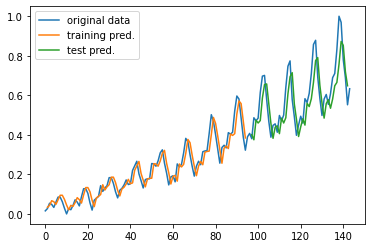

In [17]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label='original data')
plt.plot(trainPredictPlot, label='training pred.')
plt.plot(testPredictPlot, label='test pred.')
plt.legend()